In [33]:
import io
import boto3
import numpy as np
from PIL import Image
from dotenv import dotenv_values

IMG_PATH = "../data/test_data/REGION_1-24_0_1024_0_1024.jpg"
ENDPOINT_NAME = ""

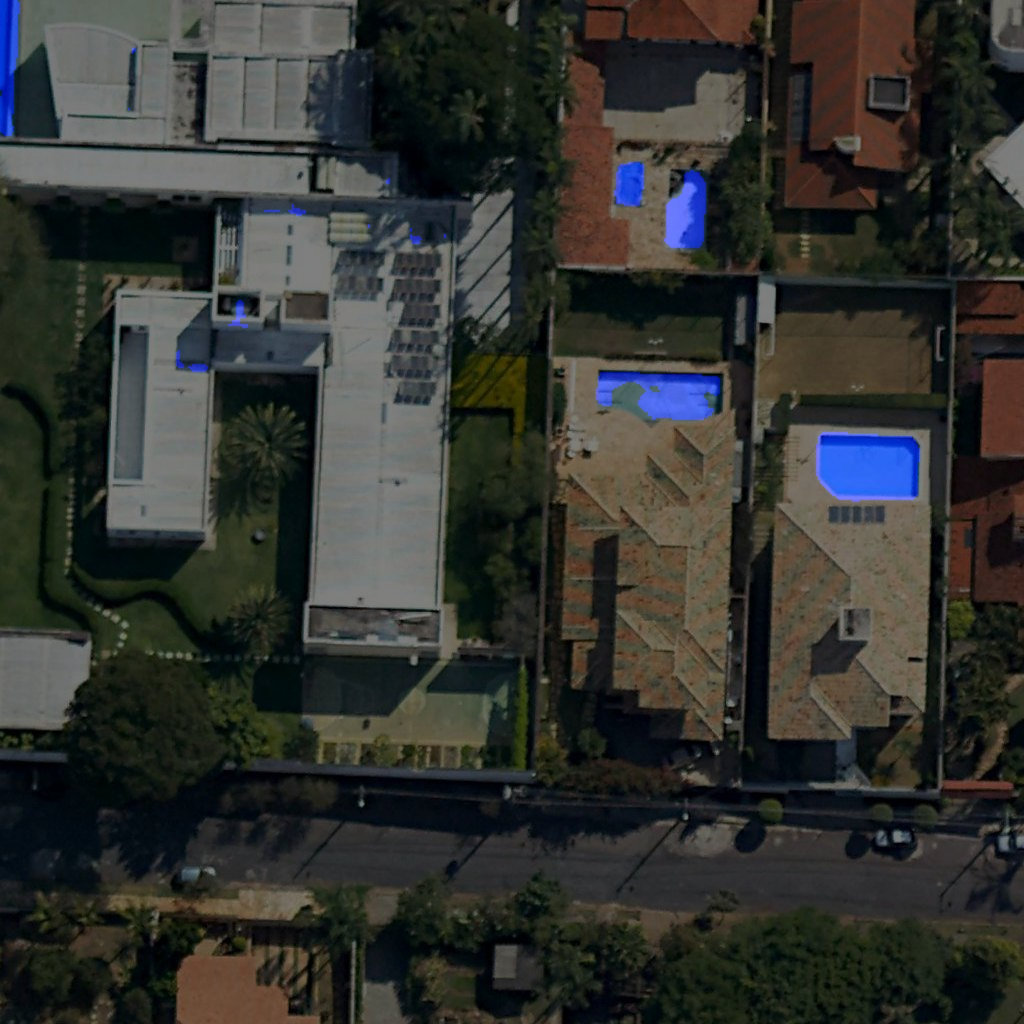

In [34]:
with open(IMG_PATH, "rb") as f:
    payload = f.read()

runtime= boto3.client('runtime.sagemaker',
                      aws_access_key_id=dotenv_values("../.env")["AWS_ACCESS_KEY_ID"], 
                      aws_secret_access_key=dotenv_values("../.env")["AWS_SECRET_ACCESS_KEY"], 
                      region_name="us-east-2")

response  = runtime.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    Body=payload,
    ContentType='image/jpeg',
)

with io.BytesIO(response['Body'].read()) as f:
    f.seek(0)
    pred_mask = np.squeeze(np.load(f))


def paint_mask(mask, color_map={0: (0, 0, 0), 1: (0, 0, 255)}):
    vis_shape = mask.shape + (3,)
    vis = np.zeros(vis_shape)
    for i, c in color_map.items():
        vis[mask == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

img_pil = Image.open(IMG_PATH)
overlay_img_pil = Image.blend(
    img_pil.convert("RGBA"), 
    paint_mask(pred_mask).convert("RGBA").resize(img_pil.size), 
    0.5
)

display(overlay_img_pil)